# Семинар 17. Scipy_2

1. `scipy.integrate`


2. **`scipy.interpolate`**
    - интерполяция скалярных функций `interp1d`, `InterpolatedUnivariateSpline`
    - интерполяция векторных функций `interp1d`
    - интерполяция скалярных функций двух переменных


3. **`scipy.optimize`**
    - root
    - fminbound
    - minimize


4. ...

https://docs.scipy.org/doc/scipy/reference/

In [1]:
!pip install --user -U scipy

Requirement already up-to-date: scipy in c:\users\stasb\anaconda3\envs\p38\lib\site-packages (1.6.3)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

C:\Users\stasb\Anaconda3\envs\p38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\stasb\Anaconda3\envs\p38\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\stasb\Anaconda3\envs\p38\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\stasb\Anaconda3\envs\p38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Интерполяция скалярных функций

### `interp1d`

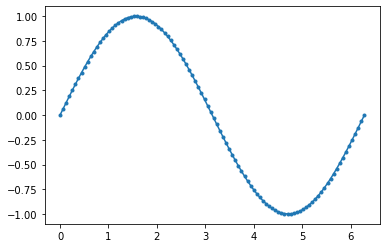

In [3]:
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

plt.plot(x, y, '.-')

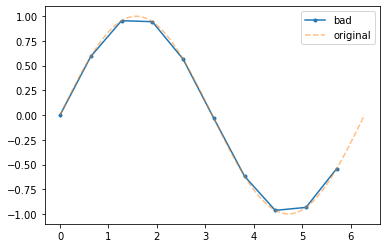

In [5]:
# предположим, что часть данных пропала

x_bad = x[::10]
y_bad = y[::10]

plt.plot(x_bad, y_bad, '.-', label='bad')
plt.plot(x, y, '--', alpha=0.5, label='original')
plt.legend()

In [6]:
# попробуем восстановить утраченные данные

In [7]:
from scipy.interpolate import interp1d

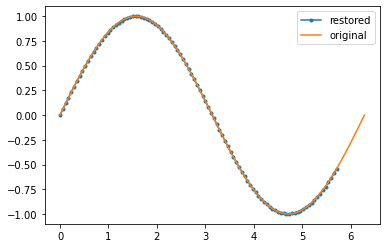

In [7]:
# построение кубического сплайна
f = interp1d(x_bad, y_bad, kind='cubic')

# создаем новый набор точек
x_rest = np.linspace(x_bad[0], x_bad[-1], 100)

# вычисляем значение сплайна на этих точках
y_rest = f(x_rest)

plt.plot(x_rest, y_rest, '.-', label='restored')
plt.plot(x, y, label='original')
plt.legend()

### `InterpolatedUnivariateSpline`

**Задача**

В файле `sample_trajectory.txt` находится табличное представление траектории движения космического аппарата. 

Столбцы: $t, x, y, z, \dot x, \dot y, \dot z$. Время измеряется в днях, положение - в км, скорость - в км/с.

Найти минимальное расстояние от кривой до Земли с координатами $(0, 0, 0)$.

Решение, полученное с погрешностью 1e-12: 

$t = 185.631822567655$

$r = 57254.75524794735$

In [8]:
t_p = 185.631822567655
rmag_p = 57254.75524794735

In [9]:
arr = np.loadtxt('sample_trajectory.txt')
arr.shape

(106, 7)

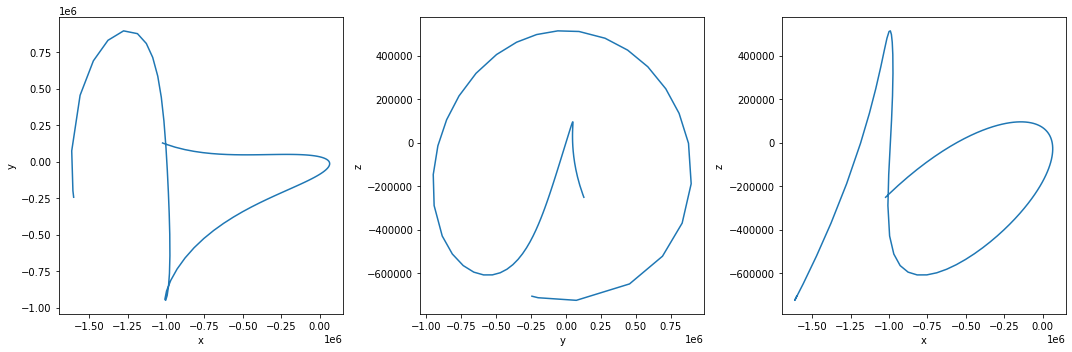

In [10]:
# Изображение трех проекций
fig, ax = plt.subplots(1, 3, figsize=(15,5))

axes = "xyz"
for i, (cx, cy) in enumerate([(1, 2), (2, 3), (1, 3)]):
    ax[i].plot(arr[:,cx], arr[:,cy])
    ax[i].set_xlabel(axes[cx-1])
    ax[i].set_ylabel(axes[cy-1])
    
fig.tight_layout()

In [12]:
# для удобства
t = arr[:, 0]
r = arr[:, 1:4]
v = arr[:, 4:]

In [13]:
# нулевое приближение - минимум по таблице
rmag = np.linalg.norm(r, axis=1)
idx = np.argmin(rmag)
rmag_0 = np.linalg.norm(r[idx])
t_0 = t[idx]

print('t_0', t_0)
print('rmag_0', rmag_0)
print('err_t', t_p - t_0)
print('err_rmag', abs(rmag_0 - rmag_p))

t_0 185.62337155598004
rmag_0 57284.454309501605
err_t 0.008451011674964093
err_rmag 29.699061554252694


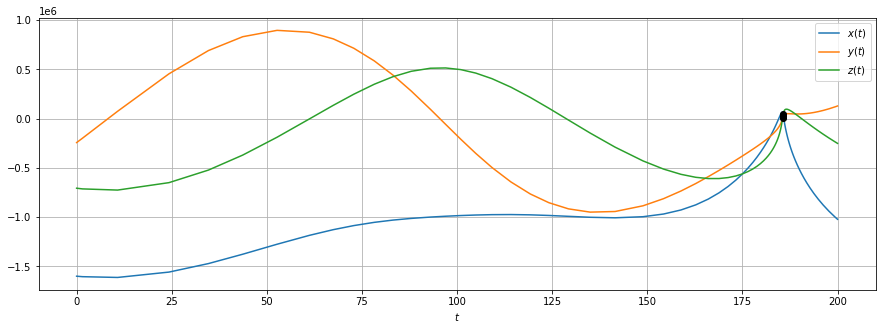

In [14]:
# plot x(t), y(t), z(t)
plt.figure(figsize=(15, 5))
plt.plot(t, r)
plt.plot(t[None, idx], r[None, idx], 'ok')
plt.legend(['$x(t)$', '$y(t)$', '$z(t)$'])
plt.xlabel('$t$')
plt.grid();

In [15]:
# сплайн для векторной функции = сразу 6 сплайнов по каждой координате
spl = interp1d(arr[:, 0], arr[:, 1:], axis=0, kind='cubic')
spl(10) # расчет для t = 10 дней

array([-1.61396677e+06,  5.12711837e+04, -7.26897464e+05,  9.82316320e-03,
        3.44043524e-01,  1.22607261e-02])

In [16]:
# скалярное произведение r@v обращается в 0 в перицентре (апоцентре)
rdotv = np.sum(r * v, axis=1)

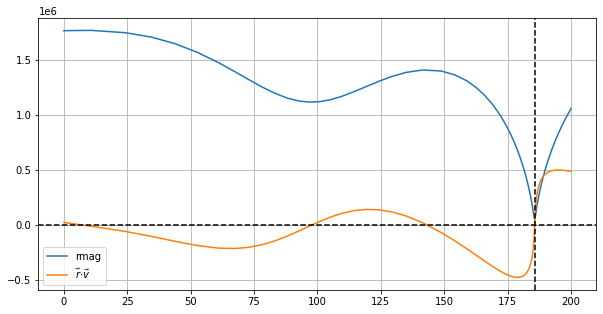

In [17]:
# изображение rmag и r@v
plt.figure(figsize=(10, 5))
plt.plot(t, rmag, label='rmag')
plt.plot(t, rdotv, label=r'$\vec{r} {\cdot} \vec{v}$')
plt.axvline(t_0, ls='--', color='k')
plt.axhline(0, ls='--', color='k')
plt.grid()
plt.legend();

In [18]:
# первый способ - уточнение корня при помощи `scipy.optimize.root`
from scipy.optimize import root

In [19]:
# функция для вычисления r@v
def rdotv_func(t, trj):
    s = trj(t[0])
    r = s[:3]
    v = s[3:]
    return r @ v

In [20]:
# уточнение корня
res = root(rdotv_func, t_0, args=(spl, ), tol=1e-12)
res

    fjac: array([[-1.]])
     fun: 5.718902684748173e-09
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-5.71890268e-09])
       r: array([-551322.65488325])
  status: 1
 success: True
       x: array([185.63182239])

In [21]:
t_1 = res.x[0]
rmag_1 = np.linalg.norm(spl(t_1)[:3])
print('t_1', t_1)
print('rmag_1', rmag_1)
print('err_t', t_p - t_1)
print('err_rmag', abs(rmag_1 - rmag_p))

t_1 185.63182238518246
rmag_1 57254.664779290164
err_t 1.8247254729431006e-07
err_rmag 0.09046865718846675


In [22]:
# второй способ - использовать другой инструмент для интерполяции
from scipy.interpolate import InterpolatedUnivariateSpline

In [25]:
# построение сплайна и вычисление его корней
spl_rdv = InterpolatedUnivariateSpline(arr[:,0], rdotv, k=3)
roots = spl_rdv.roots()
roots

array([  7.73980119,  97.62568891, 143.44513498, 185.6318226 ])

In [26]:
t_2 = roots[-1]
rmag_2 = np.linalg.norm(spl(t_2)[:3])
print('t_2', t_2)
print('rmag_2', rmag_2)
print('err_t', t_p - t_2)
print('err_rmag', abs(rmag_2 - rmag_p))

t_2 185.6318226005544
rmag_2 57254.66477667423
err_t -3.2899379220907576e-08
err_rmag 0.09047127312078374


### Задание

Найти минимальное расстояние, минимизировав функцию расстояния до точки $(0, 0, 0)$. Алгоритм минимизации использовать `scipy.optimize.fminbound`.

`fminbound(f, a, b, args, xtol)`, где
- f(x, *args) - минимизируемая функция
- a, b - отрезок поиска минимума
- args - дополнительные параметры функции f
- xtol - погрешность по значению аргумента x

## Интерполяция скалярных функций двух переменных

### Задача

Наити минимумы поверхности, заданной таблично в файле `sample_surface.txt`.

Столбцы `raan, ta, type, rmag, dv`. 

Поверхность задана как `dv(raan, ta)`.

Где столбец `type` == 0, значение `dv` не определено.

In [24]:
import pandas as pd

In [25]:
df = pd.read_csv('sample_surface.txt', sep='\s+')
df.head()

,raan,ta,type,rmag,dv
0,0,0,1,0,0.854865
1,0,10,1,0,0.843530
2,0,20,1,0,0.832645
3,0,30,1,0,0.822409
4,0,40,1,0,0.813098


In [26]:
m = df.dv.max()
m

0.8988922119140627

In [27]:
dfp = df[df.type == 1].pivot(index='ta', columns='raan', values='dv').fillna(0.9)
dfp.head()

raan,0,10,20,30,40,50,60,70,80,90,...,270,280,290,300,310,320,330,340,350,360
ta,,,,,,,,,,,,,,,,,,,,,
0,0.854865,0.808969,0.770517,0.741559,0.721078,0.706668,0.696213,0.688321,0.682233,0.677554,...,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.854865
10,0.843530,0.805417,0.771469,0.744122,0.723679,0.708847,0.697971,0.689813,0.683597,0.678918,...,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.882541,0.843530
20,0.832645,0.802258,0.773438,0.748416,0.728384,0.713168,0.701788,0.693265,0.686884,0.682224,...,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.890057,0.862418,0.832645
30,0.822409,0.799905,0.777026,0.755402,0.736514,0.721143,0.709195,0.700177,0.693539,0.688916,...,0.900000,0.900000,0.900000,0.900000,0.900000,0.891568,0.878110,0.862006,0.843338,0.822409
40,0.813098,0.798999,0.783463,0.767175,0.751190,0.736679,0.724457,0.714871,0.707877,0.703372,...,0.867114,0.866501,0.864706,0.861713,0.857437,0.851807,0.844684,0.835931,0.825430,0.813098


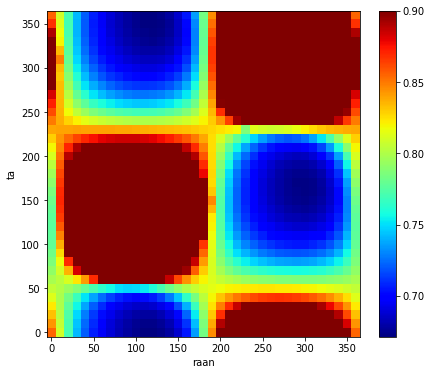

In [28]:
plt.figure(figsize=(7, 6))
plt.pcolormesh(dfp.index, dfp.columns, dfp, shading='auto', cmap='jet')
plt.colorbar()
plt.xlabel('raan')
plt.ylabel('ta');

In [29]:
from scipy.interpolate import RectBivariateSpline

In [30]:
# построение двумерной сплайновой поверхности на прямоугольной сетке
spl2d = RectBivariateSpline(dfp.index, dfp.columns, dfp)

In [31]:
ta = np.arange(0, 360, 1)
raan = ta

In [32]:
surf = spl2d(raan, ta)

Text(0, 0.5, 'ta')

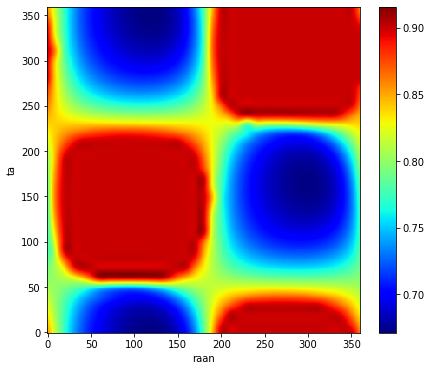

In [33]:
plt.figure(figsize=(7, 6))
plt.pcolormesh(raan, ta, surf, shading='auto', cmap='jet')
plt.colorbar()
plt.xlabel('raan')
plt.ylabel('ta')

In [34]:
from scipy.optimize import minimize

In [35]:
def fun(x, spl):
    return spl(x[1], x[0])[0, 0]

In [36]:
res = minimize(fun, np.array([300, 170]), 
               method='SLSQP', args=(spl2d,), 
               options={'ftol':1e-9})
res

     fun: 0.6722338835560903
     jac: array([-1.24499202e-05,  4.21702862e-06])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([298.43940036, 165.39400579])

Text(0, 0.5, 'ta')

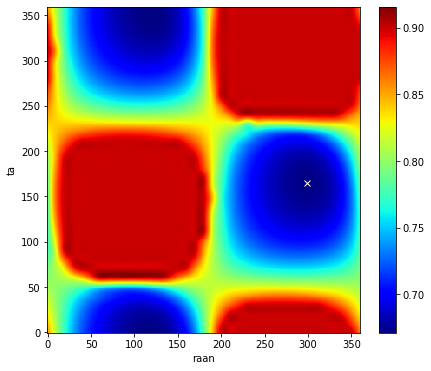

In [37]:
plt.figure(figsize=(7, 6))
plt.pcolormesh(raan, ta, surf, shading='auto', cmap='jet')
plt.plot(*res.x, 'xw')
plt.colorbar()
plt.xlabel('raan')
plt.ylabel('ta')

### Задание

Модифицировать функцию `fun` так, чтобы координаты, которые она передает в `spl`, всегда находились на отрезке $[0, 360]$. Найти локальный минимум `spl2d`, взяв за начальное приближение $(120, 10)$. Отобразить найденный минимум поверх цветовой карты.

### Задание

Написать функцию `jac`, которая будет рассчитывать Якобиан `spl` в точке `x`. Использовать функцию для ускорения расчета минимума `spl2d` и сравнить время поиска минимума в обоих случаях.